Colas Drutinus--Cabin  et  Jenanan Mailanandam

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Etude de cas en optimisation</div>
<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Maintenance</div>

Nous avons essayé dans ce projet d'optimiser la maintenance des unités de production des centrales thermiques de l'île de la Réunion. Pour cela, nous avons cherché à minimiser le coût lié à cette maintenance.

La librairie d'optimisation utilisée est [Gurobi](https://www.gurobi.com/). Une licence académique a été utilisée pour faire ce projet. Les solvers associés à cette librairie sont plus performants que ceux utilisés par Pulp, et elle permet de faire de l'optimisation non-linéaire, comme fait dans ce notebook.

Pour des raisons de temps de calcul, nous avons assuré un planning de maintenance seulement sur un mois (et non une année) car la quantité de données, et donc de variables est très grande. Un axe d'approfondissement de ce projet est de lancer l'optimisation sur le cloud, notamment avec des GPUs, puisque la librairie Gurobi permet un accès au cloud. Malheureusement, ce dernier requiert une licence payante.


1. [Données](#sec1)
    1. [Données de consommation](#sec1-1)
    2. [Données des centrales](#sec1-2)
2. [Optimisation](#sec2)
    1. [Données](#sec2-1)
    2. [Variables](#sec2-2)
    3. [Contraintes](#sec2-3)
    4. [Objectif](#sec2-4)
    5. [Simulation](#sec2-5)
3. [Résultats](#sec3)
    1. [Equilibre Offre/Demande](#sec3-1)
    2. [Date de maintenance pour chaque unité](#sec3-2)

In [516]:
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# <a id="sec1"></a> 1. Données
## <a id="sec1-1"></a> A. Données de consommation

Les données de consommation sont tirées de la base de données d'EDF et concernent l'année 2017.

In [517]:
data = pd.read_csv("data/data.csv", sep=';')

data.head()

,Date,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Hydraulique (MW),Photovoltaïque (MW),Eolien (MW),Bioénergies (MW)
0,01/01/2017 04:00,258.452,29.471,198.937,29.183,-0.434,-0.059,1.353
1,01/01/2017 05:00,251.673,30.472,194.092,26.283,-0.427,-0.060,1.313
2,01/01/2017 06:00,242.021,30.010,181.286,29.805,-0.359,-0.062,1.341
3,01/01/2017 07:00,233.028,24.341,173.220,22.226,11.997,-0.042,1.285
4,01/01/2017 08:00,245.900,14.836,163.957,19.252,46.460,0.030,1.365


Les productions renouvelables sont regroupées car elles ne seront pas sujettes à l'optimisation de ce notebook.

In [518]:
data["Consommation renouvelable (MW)"] = data.loc[:,"Hydraulique (MW)":"Bioénergies (MW)"].sum(axis=1)

data = data.drop(['Hydraulique (MW)', 'Photovoltaïque (MW)', 'Eolien (MW)',
                 'Bioénergies (MW)'], axis=1)

data.head()

,Date,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Consommation renouvelable (MW)
0,01/01/2017 04:00,258.452,29.471,198.937,30.043
1,01/01/2017 05:00,251.673,30.472,194.092,27.109
2,01/01/2017 06:00,242.021,30.010,181.286,30.725
3,01/01/2017 07:00,233.028,24.341,173.220,35.466
4,01/01/2017 08:00,245.900,14.836,163.957,67.107


## <a id="sec1-2"></a> B. Données des centrales

Les données sur les centrales sont celles qui nous ont été communiquées sur LMS par les intervenants d'EDF.

In [519]:
data_centrales = pd.read_csv("data/maintenance.csv", sep=';')

data_centrales.head()

,centrale,type,Pmax (MW),nb unités,capacité totale (MW),Pmin (MW),durée minimum marche et arrêt (h),taux annuel arrêt fortuit (%),durée arrêt fortuit (j),nombre maintenances par an par unité,durée maintenance (j),coût marginal (€/MWh),coût de démarrage (€)
0,Bois Rouge,bagasse/charbon,33,3,100,10,6,"0,05",7,1,21,40,50000
1,Le Gol,bagasse/charbon,37,3,111,10,6,"0,05",7,1,21,40,50000
2,La Baie,TAC,40,2,80,15,1,"0,05",7,1,21,150,2000
3,Le Port Est,diesel,18,12,216,0,1,"0,05",7,1,21,80,1000


# <a id="sec2"></a> 2. Optimisation
## <a id="sec2-1"></a> A. Données

Notre durée d'étude est définie dans ces paramètres. Nous ajouterons cependant une semaine de plus, lors de laquelle la maintenance ne pourra plus être faite, afin de reprendre un rythme "normal" (sans maintenance) des centrales.

In [520]:
# Durée d'étude (en heures) de maintenance
n_maintenance = 24*7

# Durée d'étude (en heures) totale
n = n_maintenance + 24*7


# Demande en énergie
demande = data['Consommation (MW)'][:n]


# La production d'énergies renouvelables
prod_renew = data["Consommation renouvelable (MW)"]


# Liste qui contient les puissances minimales de fonctionnement
# de chaque unité de production thermique
pmin = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        pmin.append(data_centrales['Pmin (MW)'][i])

        
# Liste qui contient les puissances maximales de fonctionnement
# de chaque unité de production thermique
pmax = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        pmax.append(data_centrales['Pmax (MW)'][i])


# Liste qui contient les durées de maintenance (en jours)
# de chaque unité de production thermique
# La durée de maintenance est adaptée à la durée d'étude totale
duree_maint = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        duree = data_centrales['durée maintenance (j)'][i]*n_maintenance*24/data.shape[0]
        duree_maint.append(duree)

        
# Liste qui contient les coûts variables
# de chaque unité de production thermique
cout_var = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        cout_var.append(data_centrales['coût marginal (€/MWh)'][i])

        
# Liste qui contient les coûts fixes
# de chaque unité de production thermique        
cout_fixe = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        cout_fixe.append(data_centrales['coût de démarrage (€)'][i])

In [521]:
print("Pmin:",pmin)
print("Pmax:",pmax)
print("Durées:",duree_maint)
print("Coûts variables:",cout_var)
print("Coûts fixes:",cout_fixe)

Pmin: [10, 10, 10, 10, 10, 10, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pmax: [33, 33, 33, 37, 37, 37, 40, 40, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Durées: [9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535, 9.665753424657535]
Coûts variables: [40, 40, 40, 40, 40, 40, 150, 150, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Coûts fixes: [50000, 50000, 50000, 50000, 50000, 50000, 2000, 2000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


## <a id="sec2-2"></a> B. Variables

In [522]:
# Création du modèle
model = gp.Model('Maintenance')

# Variables de production pour chaque unité pour chaque pas de temps
var_prod = []
for i in range(len(pmin)):
    prod = []
    for t in range(n):
        prod.append(model.addVar(lb=0,ub=pmax[i],vtype=GRB.CONTINUOUS, name="prod_{}_{}".format(i,t)))
    var_prod.append(prod)

# Variables on/off pour chaque unité pour chaque pas de temps
var_on = []
for i in range(len(pmin)):
    on = []
    for t in range(n):
        on.append(model.addVar(vtype=GRB.BINARY, name="on_{}_{}".format(i,t)))
    var_on.append(on)

# Variables de démarrage pour chaque unité pour chaque pas de temps.
# Vaut 1 si on vient d'allumer l'unité
var_demarrage = []
for i in range(len(pmin)):
    demarrage = []
    for t in range(n):
        demarrage.append(model.addVar(vtype=GRB.BINARY, name="demarrage_{}_{}".format(i,t)))
    var_demarrage.append(demarrage)
    
# Variables de début de maintenance pour chaque unité.
# Vaut 1 au moment t si on démarre la maintenace de l'unité
var_maint = []
for i in range(len(pmin)):
    var_maint.append([model.addVar(vtype=GRB.BINARY, name="maint_{}_{}".format(i,t)) for t in range(n_maintenance)])
    
# Batterie
capamax = 25
cout_batterie = 15

# Variables de stockage de la batterie
stock_batterie = [model.addVar(lb=0,ub=capamax,vtype=GRB.CONTINUOUS, name="stock_batterie_{}".format(t)) for t in range(n)]
# Variables d'utilisation de la batterie
prod_batterie = [model.addVar(lb=0,ub=capamax,vtype=GRB.CONTINUOUS, name="use_batterie_{}".format(t)) for t in range(n)]

## <a id="sec2-3"></a> C. Contraintes

In [523]:
# Batterie initialement vide
model.addConstr(stock_batterie[0] == 0)

## Maintenance
for i in range(len(var_maint)):
    duree = int(duree_maint[i])
    
    # La maintenance doit être faite
    model.addConstr(sum([var_maint[i][t] for t in range(n_maintenance-duree)]) == 1)
    
    # Lorsque l'usine est en maintenance, elle est à l'arrêt
    for t in range(n_maintenance-duree):
        for day in range(duree):
            model.addConstr(var_on[i][t+day] <= 1-var_maint[i][t])

for t in range(n):

    for i in range(len(var_prod)):
        
        # Toutes les unités produisent entre pmin et pmax (et 0 si elles sont à l'arrêt)
        model.addConstr(var_prod[i][t] >= pmin[i]*var_on[i][t])
        model.addConstr(var_prod[i][t] <= pmax[i]*var_on[i][t])
        
            # Au début, les usines étaient déjà en route
        model.addConstr(var_demarrage[i][0] == 0)
        
    ## Batterie
    # Limite d'utilisation de la batterie
    model.addConstr(prod_batterie[t] <= stock_batterie[t])
    
    if t>0:
        # Rechargement de la batterie basé sur la production de l'heure précédente
        prod_t_prec = 0
        for i in range(len(var_prod)):
            prod_t_prec += var_prod[i][t-1]
            
            # Le coût au démarrage : Vaut 1 si on allume une unité
            model.addConstr(var_demarrage[i][t] == (var_on[i][t] - var_on[i][t-1])*(1-var_on[i][t-1]))
            
            
        prod_t_prec += prod_batterie[t-1]
        prod_t_prec += prod_renew[t-1]

        model.addConstr(stock_batterie[t] == stock_batterie[t-1] - prod_batterie[t-1] + prod_t_prec - demande[t-1])
        
        
    # La production totale doit subvenir à la demande
    prod_t = gp.quicksum(var_prod[i][t] for i in range(len(var_prod)))
    model.addConstr(prod_t + prod_renew[t] + prod_batterie[t] >= demande[t])

## <a id="sec2-4"></a> D. Objectif

In [524]:
start = time.time()
cout = 0
for t in range (n):
    for i in range(len(var_prod)):
        # Coûts variables de production
        cout += var_prod[i][t]*cout_var[i]
        
        # Coûts fixes de démarrage de la production
        cout += var_demarrage[i][t]*cout_fixe[i]
    
    # Coût d'utilisation de la batterie
    cout += prod_batterie[t]*cout_batterie

model.setObjective(cout, GRB.MINIMIZE)
end = time.time()

print("Time : {}s".format(round(end-start,2)))

Time : 0.05s


## <a id="sec2-5"></a> E. Simulation

In [525]:
start = time.time()
model.optimize()
end = time.time()

print("Time : {}s".format(round(end-start,2)))

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 49808 rows, 24192 columns and 105087 nonzeros
Model fingerprint: 0x59f372f3
Model has 6700 quadratic constraints
Variable types: 7392 continuous, 16800 integer (16800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e+01, 5e+04]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 3e+02]
Presolve removed 15935 rows and 202 columns
Presolve time: 0.48s
Presolved: 33873 rows, 23990 columns, 115946 nonzeros
Variable types: 7390 continuous, 16600 integer (16600 binary)
Found heuristic solution: objective 9740200.4350
Found heuristic solution: objective 6730246.6700

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual I

On sauvegarde les résultats dans un fichier de solution. Dans le cadre d'une simulation longue, il sera toujours possible de charger les valeurs optimales plutôt que de relancer la simulation.

In [526]:
model.write("solutions.sol")

# <a id="sec3"></a> 3. Résultats
## <a id="sec3-1"></a> A. Equilibre Offre/Demande

In [527]:
def display_results(start_plot, end_plot, verbose=False):
    "Fonction qui permet d'afficher la courbe d'équilibre offre/demande"
    "entre deux dates (en heures)."
    "Le paramètre verbose permet d'afficher le détail de production"
    "de chaque centrale thermique"

    fig = plt.figure(figsize=(12,8))
    plt.plot(demande,'b', label='Demande')

    current_site = 0
    prod = []
    #Pour chaque usine
    for j in range (data_centrales.shape[0]):
        plant_j = []

        #Pour chaque jour
        for t in range(n):
            prod_t = 0

            #Pour chaque unité de production
            for i in range(current_site, current_site + data_centrales['nb unités'][j]):
                prod_t += var_prod[i][t].x
            plant_j.append(prod_t)

        current_site += data_centrales['nb unités'][j]
        prod.append(plant_j)
        
        if verbose:
            plt.plot(plant_j,label=data_centrales['centrale'][j])
            
    prod_totale = [sum([prod[i][t] for i in range(len(prod))]) + prod_renew[t] + prod_batterie[t].x for t in range(n)]


    plt.plot(prod_totale, label='Prod totale')

    plt.legend(loc='upper right')
    plt.xlim(start_plot,end_plot)
    plt.xlabel("Temps (heures)")
    plt.ylabel("Energie (MW)")
    plt.title("Equilibre offre/demande")
    plt.show()

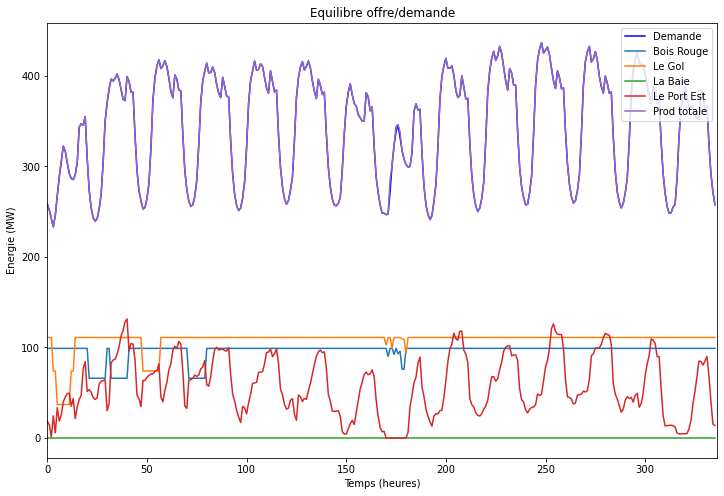

In [529]:
start = 0
end = n
verbose = True

display_results(start,end,verbose)

## <a id="sec3-2"></a> B. Date de maintenance pour chaque unité

In [530]:
names_unite = []
centrale = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        names_unite.append(data_centrales['centrale'][i]+" - " + str(k))
        centrale.append(data_centrales['centrale'][i])
        
date_maintenance = []        
for i in range(len(var_maint)):
    list_maintenance = [var_maint[i][t].x for t in range(n_maintenance)]
    ind = list_maintenance.index(max(list_maintenance))
    date_maintenance.append(ind)

df_maintenance = pd.DataFrame()
df_maintenance["Centrale"] = centrale
df_maintenance["Unités de production"] = names_unite
df_maintenance["Date de maintenance"] = date_maintenance
df_maintenance["Durée de maintenance (h)"] = [int(maint) for maint in duree_maint]

df_maintenance

,Centrale,Unités de production,Date de maintenance,Durée de maintenance (h)
0,Bois Rouge,Bois Rouge - 0,71,9
1,Bois Rouge,Bois Rouge - 1,21,9
2,Bois Rouge,Bois Rouge - 2,32,9
3,Le Gol,Le Gol - 0,3,9
4,Le Gol,Le Gol - 1,48,9
5,Le Gol,Le Gol - 2,5,9
6,La Baie,La Baie - 0,0,9
7,La Baie,La Baie - 1,0,9
8,Le Port Est,Le Port Est - 0,66,9
9,Le Port Est,Le Port Est - 1,95,9


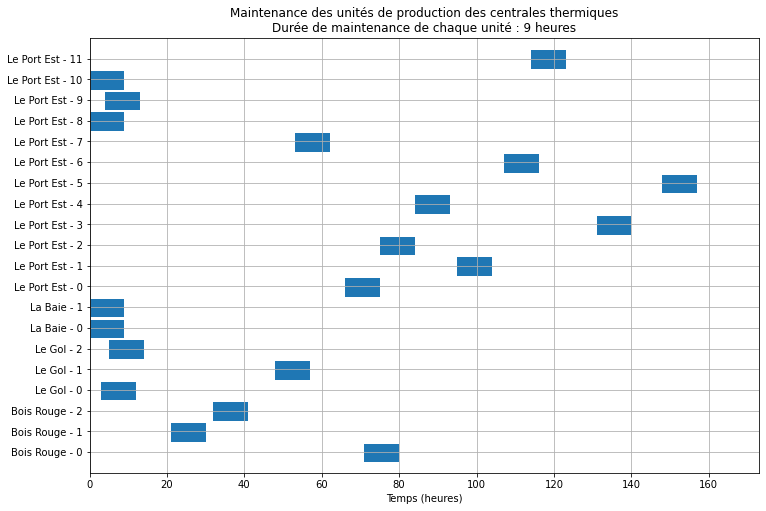

In [531]:
fig, ax = plt.subplots(figsize=(12,8))
for i in range(len(df_maintenance["Centrale"])):
    ax.broken_barh([(df_maintenance["Date de maintenance"][i],df_maintenance["Durée de maintenance (h)"][i])],
                  (10*(i+1), 9), facecolors=('tab:blue'))
ax.set_ylim(5, (len(df_maintenance["Centrale"])+1)*10 +5)
ax.set_xlim(0, n_maintenance+5)
ax.set_xlabel('Temps (heures)')
ax.set_yticks([10*(i+1) + 5 for i in range(len(df_maintenance["Centrale"]))])
ax.set_yticklabels(df_maintenance["Unités de production"])
ax.set_title("Maintenance des unités de production des centrales thermiques\n"+
            "Durée de maintenance de chaque unité : {} heures".format(df_maintenance["Durée de maintenance (h)"][0]))
ax.grid(True)

plt.show()

Vous pouvez retrouver ce notebook sur [Github](https://github.com/cdrutinus/case_study_PPE)